# Age discrepancy

Now we will try to correlate age discrepancy with some scores of the behavioral dataset. Our model to predict age uses only the structural MRI features.
Thing I would like to check: MULTIPLE TESTING/INBALANCE PROBLEMS?

In [1]:
import warnings
warnings.filterwarnings('ignore')
from utils import create_dataset_mri, cv_for_cde, create_dataset_eeg
from cde.density_estimator import MixtureDensityNetwork
import numpy as np
import tensorflow as tf
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.python.keras.activations import tanh
from sklearn.impute import SimpleImputer
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# Behavioral data
behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
# Create dataset MRI
target = 'Age'
data = create_dataset_mri(SCORE = target)
data.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)

In [3]:
# labels and features
y = data[target]
X = data.drop([target], axis=1)
X = np.array(X)
y = np.array(y)

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=3)
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
ID_train = X_train[:,0]
X_train = X_train[:,1:]
ID_test = X_test[:,0]
X_test = X_test[:,1:]
y_train = np.array(y_train, dtype=np.float64)
X_train = np.array(X_train, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64)
print(X_train.shape)

(458, 369)


In [4]:
# Set model parameters
ndim_x=X_train.shape[1]
ndim_y=y_train.shape[1]
# We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
n = X_train.shape[0]
d = X_train.shape[1]+y_train.shape[1]
h = n**(-1/(d+1))
# Define the model
model = MixtureDensityNetwork('MDN', ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=1000, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
# Fit
model.fit(X_train, y_train)
# Predict
y_pred = model.mean_(X_test)
y_pred = y_pred.reshape((-1,1))
y_pred.shape
print('Test MSE: {}'.format(mean_squared_error(y_pred, y_test)))

1000/1000 [100%] ██████████████████████████████ Elapsed: 10s | loss: 683.500
mean log-loss train: 1.4924
Test MSE: 5.576091747263413


In [5]:
# Define discrepancy
std = model.std_(X_test)
discrepancy = np.divide((y_test-y_pred), std)
#discrepancy = y_test-y_pred

In [6]:
# Get dataframe for test observations with behavioral data + discrepancy
data = {'discrepancy':discrepancy[:,0]}
discrepancy_df = pd.DataFrame(data)
ID_df = pd.DataFrame({'EID':ID_test})
discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
dataframe = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
dataframe = dataframe.drop(['Anonymized.ID', 'Study.Site'], axis = 1)

In [7]:
# Get the correlations
correlations = dataframe[dataframe.columns[1:]].corr()['discrepancy'][:]
# Inspect correlations
correlations[correlations > 0.3]  

discrepancy       1.000000
Age               0.387244
DX_06_RC          0.556176
DX_06_Rem         0.403055
DX_07_ByHx        1.000000
CAARS_HR_Raw      0.369105
CELF_WC_R         0.406347
CELF_FS_R         0.377634
EVT2_RawScore     0.302995
KBIT_NV_Raw       0.495252
KBIT_V_Raw        0.623206
PPVT4_RawScore    0.360499
STAI_SA_T         0.315422
WASI_Vocab_Raw    0.309599
WASI_BD_Raw       0.366970
WIAT_Num_Raw      0.306304
WIAT_MP_Raw       0.305069
Name: discrepancy, dtype: float64

In [8]:
# Frequencies of major disturb in behavioral dataset
dataframe['DX_01'].value_counts()

ADHD-Combined Type                                                  130
ADHD-Inattentive Type                                               118
No Diagnosis Given                                                   90
Autism Spectrum Disorder                                             51
No Diagnosis Given: Incomplete Eval                                  45
Specific Learning Disorder with Impairment in Reading                35
Generalized Anxiety Disorder                                         29
Major Depressive Disorder                                            22
Other Specified Attention-Deficit/Hyperactivity Disorder             19
Social Anxiety (Social Phobia)                                       16
Language Disorder                                                    13
ADHD-Hyperactive/Impulsive Type                                      13
Other Specified Anxiety Disorder                                     12
Intellectual Disability-Mild                                    

## Consider the most frequent situations: ADHD Inattentive, ADHD Combined, Autism, Healthy. Specific impairment in Reading

In [9]:
df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type', 'ADHD-Inattentive Type','No Diagnosis Given', 'Autism Spectrum Disorder'])]
# Correct for inbalance
df1 = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type'])]
df2 = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Inattentive Type'])]
df3 = dataframe.loc[dataframe['DX_01'].isin(['No Diagnosis Given'])]
df4 = dataframe.loc[dataframe['DX_01'].isin(['Autism Spectrum Disorder'])]
size = min(df1.shape[0], df2.shape[0], df3.shape[0], df4.shape[0])#, df5.shape[0])
df1 = df1.head(size)
df2 = df2.head(size)
df3 = df3.head(size)
df4 = df4.head(size)
df = df1.append(df2, ignore_index=True)
df = df.append(df3, ignore_index=True)
df = df.append(df4, ignore_index=True)


## t-test Healthy vs ADHD Inattentive

In [10]:
adhd = df[df['DX_01'] == 'ADHD-Inattentive Type']['discrepancy']
no_adhd = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
from scipy.stats import ttest_ind
res = ttest_ind(np.array(adhd), np.array(no_adhd), equal_var=False)
res

Ttest_indResult(statistic=2.3225125123606416, pvalue=0.02223297597135076)

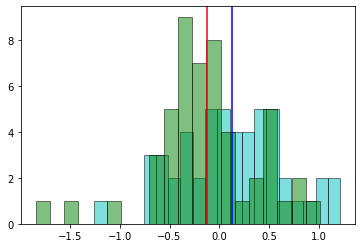

In [11]:
import matplotlib.pyplot as plt
plt.hist(adhd[:80], bins=20, color='c', edgecolor='k', alpha=0.5)     # take same number of obs as no_adhd
plt.hist(no_adhd, bins=20, color='g', edgecolor='k', alpha=0.5)
plt.axvline(x=np.mean(adhd), color = 'b')
plt.axvline(x=np.mean(no_adhd), color = 'r')

## t-test Healthy vs Autism

In [12]:
autism = df[df['DX_01'] == 'Autism Spectrum Disorder']['discrepancy']
healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
from scipy.stats import ttest_ind
res = ttest_ind(np.array(autism), np.array(healthy), equal_var=False)
res

Ttest_indResult(statistic=3.964019734405931, pvalue=0.00013876494891042519)

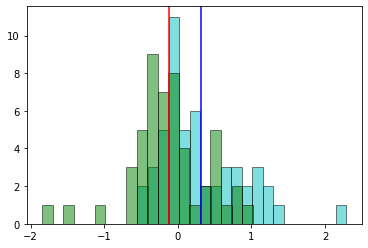

In [13]:
import matplotlib.pyplot as plt
plt.hist(autism, bins=20, color='c', edgecolor='k', alpha=0.5)     # take same number of obs as no_adhd
plt.hist(healthy, bins=20, color='g', edgecolor='k', alpha=0.5)
plt.axvline(x=np.mean(autism), color = 'b')
plt.axvline(x=np.mean(healthy), color = 'r')

# ANOVA

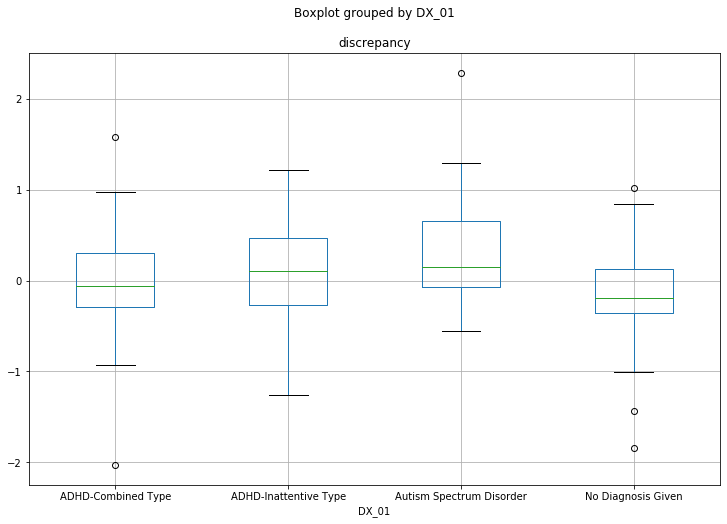

In [14]:
#Create a boxplot
df.boxplot('discrepancy', by='DX_01', figsize=(12, 8))

In [15]:
model = ols('discrepancy ~ DX_01',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)
model.summary()

             sum_sq     df         F   PR(>F)
DX_01      5.102929    3.0  5.785239  0.00082
Residual  58.804007  200.0       NaN      NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            discrepancy   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     5.785
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           0.000820
Time:                        16:29:44   Log-Likelihood:                -162.58
No. Observations:                 204   AIC:                             333.2
Df Residuals:                     200   BIC:                             346.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.0031      0.076     -0.041      0.968      -0.153       0.147
DX_01[T.ADHD-Inattentive Type]        0.1296      0.107      1.207      0.229      -0.082       0.341
DX_01[T.Autism Spectrum Disorder]     0.3110      0.107      2.896      0.004       0.099       0.523
DX_01[T.No Diagnosis Given]          -0.1146      0.107     -1.067      0.287      -0.326       0.097
==============================================================================
Omnibus:                        9.663   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               20.017
Skew:                           0.058   Prob(JB):                     4.50e-05
Kurtosis:                       4.530   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We got a significant F-test and significant pval for autism.

## Evaluate these quantities as an average over differen splits

In [16]:
def F_test(repetitions, correct_imbalance = True, multiple_testing_correction = 'fdr_bh'):
    # Behavioral data
    behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
    # Create dataset MRI
    target = 'Age'
    data = create_dataset_mri(SCORE = target)
    data.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
    # labels and features
    y = data[target]
    X = data.drop([target], axis=1)
    X = np.array(X)
    y = np.array(y)
    # things I want to compute
    F = []
    t_adhd = []
    t_adhd_combined = []
    t_autism = []
    pval_inattentive = []
    pval_combined = []
    pval_healthy = []
    pval_autism = []
    pval_reading = []
    
    for i in range(repetitions):
        # split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=i)   #rs=2
        y_train = y_train.reshape((-1,1))
        y_test = y_test.reshape((-1,1))
        ID_train = X_train[:,0]
        X_train = X_train[:,1:]
        ID_test = X_test[:,0]
        X_test = X_test[:,1:]
        y_train = np.array(y_train, dtype=np.float64)
        X_train = np.array(X_train, dtype=np.float64)
        y_test = np.array(y_test, dtype=np.float64)
        X_test = np.array(X_test, dtype=np.float64)
        # Set model parameters
        ndim_x=X_train.shape[1]
        ndim_y=y_train.shape[1]
        # We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
        n = X_train.shape[0]
        d = X_train.shape[1]+y_train.shape[1]
        h = n**(-1/(d+1))
        model = MixtureDensityNetwork('{}'.format(i), ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=1000, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
        # Fit
        model.fit(X_train, y_train)
        # Predict
        y_pred = model.mean_(X_test)
        y_pred = y_pred.reshape((-1,1))
        # Define discrepancy
        std = model.std_(X_test)
        discrepancy = np.divide((y_test-y_pred), std)
        # Get dataframe for test observations with behavioral data + discrepancy
        data = {'discrepancy':discrepancy[:,0]}
        discrepancy_df = pd.DataFrame(data)
        ID_df = pd.DataFrame({'EID':ID_test})
        discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
        dataframe = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
        dataframe = dataframe.drop(['Anonymized.ID', 'Study.Site'], axis = 1)
        # Select most frequent diseases
        df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type', 'ADHD-Inattentive Type','No Diagnosis Given', 'Autism Spectrum Disorder'])]
        if correct_imbalance == True:
            # Correct for inbalance
            df1 = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type'])]
            df2 = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Inattentive Type'])]
            df3 = dataframe.loc[dataframe['DX_01'].isin(['No Diagnosis Given'])]
            df4 = dataframe.loc[dataframe['DX_01'].isin(['Autism Spectrum Disorder'])]
            size = min(df1.shape[0], df2.shape[0], df3.shape[0], df4.shape[0])
            df1 = df1.head(size)
            df2 = df2.head(size)
            df3 = df3.head(size)
            df4 = df4.head(size)
            df = df1.append(df2, ignore_index=True)
            df = df.append(df3, ignore_index=True)
            df = df.append(df4, ignore_index=True)

        # ols model
        model = ols('discrepancy ~ DX_01', data = df).fit()
        
        # Overall F-test
        anova_result = sm.stats.anova_lm(model, typ=2)
        F.append(anova_result.loc['DX_01','PR(>F)'])
        
        # Extract pvals
        p_vals = [model.pvalues['DX_01[T.ADHD-Inattentive Type]'], model.pvalues['Intercept'], model.pvalues['DX_01[T.No Diagnosis Given]'], model.pvalues['DX_01[T.Autism Spectrum Disorder]'] ]
        
        # Correct p-values for multiple-testing
        corrected = multipletests(pvals = p_vals, alpha=0.05, method = multiple_testing_correction)
        
        # individual pvalues
        pval_inattentive.append(corrected[1][0])
        pval_combined.append(corrected[1][1])
        pval_healthy.append(corrected[1][2])
        pval_autism.append(corrected[1][3])
        
        # t-test for autism vs healthy
        autism = df[df['DX_01'] == 'Autism Spectrum Disorder']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res1 = ttest_ind(np.array(autism), np.array(healthy), equal_var=False)
        
        
        # t-test for inattentive vs healthy
        adhd = df[df['DX_01'] == 'ADHD-Inattentive Type']['discrepancy']
        no_adhd = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res2 = ttest_ind(np.array(adhd), np.array(no_adhd), equal_var=False)
        
        
        # t-test for combined vs healthy
        combined = df[df['DX_01'] == 'ADHD-Combined Type']['discrepancy']
        no_combined = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res3 = ttest_ind(np.array(combined), np.array(no_combined), equal_var=False)
        
        
        # Correct p-values for multiple-testing
        p_vals = [res1[1], res2[1], res3[1]]
        corrected = multipletests(pvals = p_vals, alpha=0.05, method = multiple_testing_correction)
        t_autism.append(corrected[1][0])
        t_adhd.append(corrected[1][1])
        t_adhd_combined.append(corrected[1][2])
    print('Mean F-test p-val: {} \n Mean ADHD Combined pval: {} \n Mean ADHD Inattentive pval. {} \n Mean Healthy pval: {} \n Mean Autism pval: {} \n  \n Mean t-test p-val (inattentive vs healthy): {} \n Mean t-test p-val (combined vs healthy): {} \n Mean t-test p-val (autism vs healthy): {}'.format(np.mean(F), np.mean(pval_combined), np.mean(pval_inattentive), np.mean(pval_healthy), np.mean(pval_autism), np.mean(t_adhd), np.mean(t_adhd_combined), np.mean(t_autism)))

In [17]:
F_test(10)

1000/1000 [100%] ██████████████████████████████ Elapsed: 10s | loss: 662.098
mean log-loss train: 1.4456
1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | loss: 688.835
mean log-loss train: 1.5040
1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | loss: 687.301
mean log-loss train: 1.5007
1000/1000 [100%] ██████████████████████████████ Elapsed: 12s | loss: 670.425
mean log-loss train: 1.4638
1000/1000 [100%] ██████████████████████████████ Elapsed: 12s | loss: 661.347
mean log-loss train: 1.4440
1000/1000 [100%] ██████████████████████████████ Elapsed: 12s | loss: 668.212
mean log-loss train: 1.4590
1000/1000 [100%] ██████████████████████████████ Elapsed: 13s | loss: 677.198
mean log-loss train: 1.4786
1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | loss: 678.908
mean log-loss train: 1.4823
1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | loss: 664.803
mean log-loss train: 1.4515
1000/1000 [100%] ██████████████████████████████ Elapsed

Using the Benjamini-Hochberg correction there is (some) evidence for autism in the t-tests!

# What if we control for Age?

In [23]:
df['Age'] = np.floor(df['Age'])
#df = df.loc[df['Age'] 15]      # AGE INTERVAL

model = ols('discrepancy ~ Age + DX_01',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

             sum_sq     df          F        PR(>F)
DX_01      2.717668    3.0   3.701932  1.265856e-02
Age       10.107275    1.0  41.303548  9.435006e-10
Residual  48.696732  199.0        NaN           NaN


In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            discrepancy   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     15.54
Date:                Wed, 20 Nov 2019   Prob (F-statistic):           4.43e-11
Time:                        11:13:01   Log-Likelihood:                -143.35
No. Observations:                 204   AIC:                             296.7
Df Residuals:                     199   BIC:                             313.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.5716      0.112     -5.087      0.000      -0.793      -0.350
DX_01[T.ADHD-Inattentive Type]        0.0088      0.100      0.088      0.930      -0.188       0.205
DX_01[T.Autism Spectrum Disorder]     0.1698      0.100      1.691      0.092      -0.028       0.368
DX_01[T.No Diagnosis Given]          -0.1604      0.098     -1.633      0.104      -0.354       0.033
Age                                   0.0649      0.010      6.427      0.000       0.045       0.085
==============================================================================
Omnibus:                       13.747   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.565
Skew:                          -0.432   Prob(JB):                     5.64e-05
Kurtosis:                       4.246   Cond. No.                         46.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

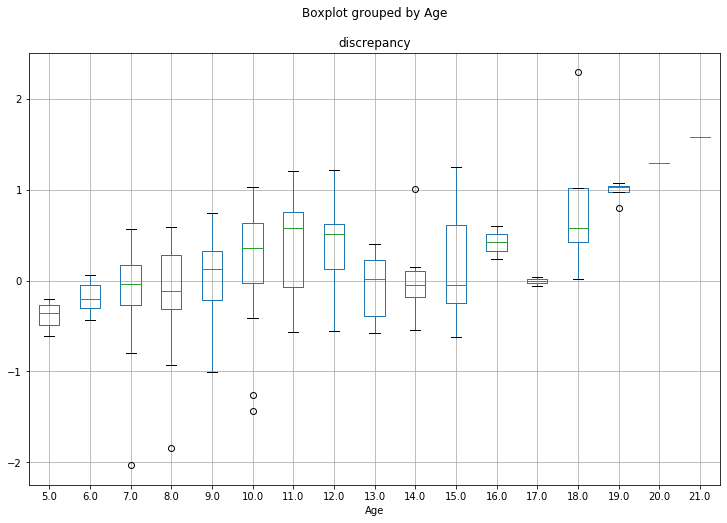

In [25]:
#Create a boxplot
df.boxplot('discrepancy', by='Age', figsize=(12, 8))

In [26]:
model = ols('Age ~ DX_01',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)
model.summary()

               sum_sq     df         F    PR(>F)
DX_01      156.882353    3.0  4.353078  0.005377
Residual  2402.627451  200.0       NaN       NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     4.353
Date:                Wed, 20 Nov 2019   Prob (F-statistic):            0.00538
Time:                        11:13:18   Log-Likelihood:                -541.02
No. Observations:                 204   AIC:                             1090.
Df Residuals:                     200   BIC:                             1103.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             8.7647      0.485     18.059      0.000       7.808       9.722
DX_01[T.ADHD-Inattentive Type]        1.8627      0.686      2.714      0.007       0.509       3.216
DX_01[T.Autism Spectrum Disorder]     2.1765      0.686      3.171      0.002       0.823       3.530
DX_01[T.No Diagnosis Given]           0.7059      0.686      1.028      0.305      -0.648       2.059
==============================================================================
Omnibus:                       18.905   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.549
Skew:                           0.786   Prob(JB):                     2.09e-05
Kurtosis:                       3.248   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
model = ols('discrepancy ~ Age',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)
model.summary()

             sum_sq     df         F        PR(>F)
Age       12.492536    1.0  49.08143  3.581192e-11
Residual  51.414400  202.0       NaN           NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            discrepancy   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     49.08
Date:                Wed, 20 Nov 2019   Prob (F-statistic):           3.58e-11
Time:                        11:13:23   Log-Likelihood:                -148.89
No. Observations:                 204   AIC:                             301.8
Df Residuals:                     202   BIC:                             308.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6168      0.105     -5.856      0.000      -0.825      -0.409
Age            0.0699      0.010      7.006      0.000       0.050       0.090
==============================================================================
Omnibus:                       16.838   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.790
Skew:                          -0.492   Prob(JB):                     2.51e-06
Kurtosis:                       4.437   Cond. No.                         31.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Boxplot for children aged <17:

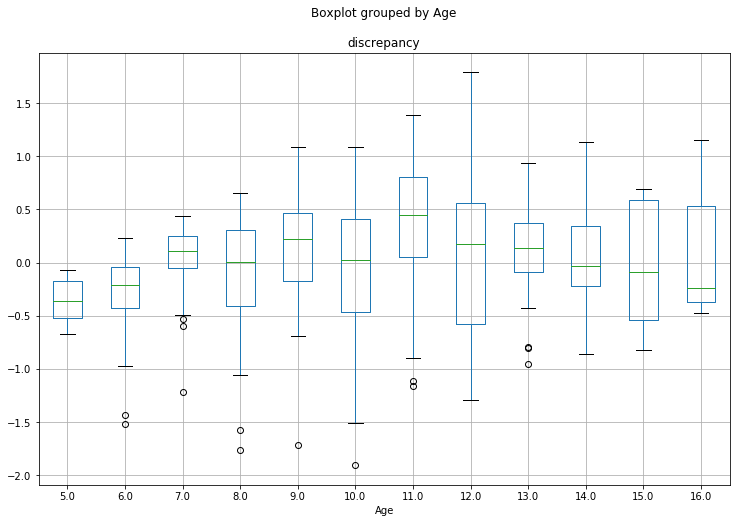

In [41]:
df['Age'] = np.floor(dataframe['Age'])
df = df.loc[df['Age']<17]
#Create a boxplot
df.boxplot('discrepancy', by='Age', figsize=(12, 8))

## Comments
Including age makes the p-val for autism less significant, but this makes sence since age is quite correlated with discrepancy of age itself (and with the diseases!)